In [1]:
import sys
sys.path.insert(0, "/home/ana-tudor/Circuit_Notebooks/lib/scikit-quant/python")
sys.path.insert(0, "/home/ana-tudor/Circuit_Notebooks/ipy_notebooks/scripts")
from skquant.opt.imfil import imfil

import itertools
import os
import time

import numpy
import pandas as pd
import pylab

import cirq
import openfermion
import openfermioncirq as ofc
from openfermioncirq.optimization import OptimizationParams, ScipyOptimizationAlgorithm
from openfermionpyscf import run_pyscf




/home/ana-tudor/quantum/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ana-tudor/quantum/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:

def h2_geometry(bond_length):
    return [
        ('H', (0.0, 0.0, 0.0)),
        ('H', (0.0, 0.0, bond_length))
    ]


def n2_geometry(bond_length):
    return [
        ('N', (0.0, 0.0, 0.0)),
        ('N', (0.0, 0.0, bond_length))
    ]


def h2o_geometry(bond_length):
    bond_angle = numpy.pi * 104.5 / 180  # 104.5 degrees
    a = bond_length * numpy.cos(bond_angle / 2.0)
    b = bond_length * numpy.sin(bond_angle / 2.0)
    return [
        ('H', (a, b, 0.0)),
        ('H', (a, -b, 0.0)),
        ('O', (0.0, 0.0, 0.0))
    ]


def generate_molecular_hamiltonian(geometry,
                                   n_active_electrons,
                                   n_active_orbitals,
                                   basis='cc-pvdz',
                                   multiplicity=1):

    # Run electronic structure calculations
    molecule = run_pyscf(
        openfermion.hamiltonians.MolecularData(
            geometry,
            basis,
            multiplicity
        )
    )

    # Freeze core orbitals and truncate to active space
    n_core_orbitals = (molecule.n_electrons - n_active_electrons) // 2
    occupied_indices = list(range(n_core_orbitals))
    active_indices = list(range(n_core_orbitals,
                                n_core_orbitals + n_active_orbitals))

    return molecule.get_molecular_hamiltonian(occupied_indices, active_indices)

In [3]:

# Create or load a variational study
# ----------------------------------

# Set directory to save studies in
STUDIES_DIR = 'studies'


# Set Hamiltonian parameters
geometry_factory = h2_geometry
bond_length = 1.4
n_active_electrons = 2
n_active_orbitals = 2
hamiltonian_name = 'H2_cc-pvdz_singlet_1.4_2-2'


# Set ansatz parameters
ansatz_class = ofc.SwapNetworkTrotterAnsatz
iterations = 1
ansatz_kwargs = {'include_all_xxyy': True}


# Generate Hamiltonian
hamiltonian = generate_molecular_hamiltonian(
    geometry_factory(bond_length),
    n_active_electrons,
    n_active_orbitals
)


# Create or load study
study_name = '{}_{}_iterations{}'.format(
    hamiltonian_name, ansatz_class.__name__, iterations)

if os.path.isfile(os.path.join(STUDIES_DIR, '{}.study'.format(study_name))):
    # Load study
    study = ofc.VariationalStudy.load(
        study_name,
        datadir=STUDIES_DIR)
    print("LOADED a variational study with {} qubits and {} parameters.".format(
        len(study.ansatz.qubits), study.num_params))
else:
    # Create study
    # Generate ansatz and objective
    hamiltonian_ferm_op = openfermion.get_fermion_operator(hamiltonian)
    ansatz_hamiltonian = openfermion.get_diagonal_coulomb_hamiltonian(
        hamiltonian_ferm_op,
        ignore_incompatible_terms=True)
    ansatz = ansatz_class(
        ansatz_hamiltonian,
        iterations=iterations,
        **ansatz_kwargs)
    objective = ofc.HamiltonianObjective(hamiltonian)

    # Use preparation circuit for mean-field state
    preparation_circuit = cirq.Circuit.from_ops(
        ofc.prepare_gaussian_state(
            ansatz.qubits,
            openfermion.QuadraticHamiltonian(ansatz_hamiltonian.one_body),
            occupied_orbitals=range(n_active_electrons)))

    study = ofc.VariationalStudy(
        study_name,
        ansatz,
        objective,
        preparation_circuit=preparation_circuit,
        datadir=STUDIES_DIR)
    print("CREATED a variational study with {} qubits and {} parameters.".format(
        len(study.ansatz.qubits), study.num_params))

LOADED a variational study with 4 qubits and 16 parameters.


In [4]:
def generate_input_params(n):
    bounds = [1,1,1,1,2,1,2,1,2,1,2,1,2,1,2,1]
    name = "imfil/16_params_init.txt"
    
    results = []
    for i in range(n):
        result = [(numpy.random.rand(1)*i-i/2).tolist()[0] for i in bounds]
#         print(result)
        results.append(numpy.array(result))
        
    return results

noise = 0.0

def cost_with_noise(noise, variance):
    if noise == 0.0:
        return None
    return variance/noise**2 * 2/numpy.pi

def eval_with_noise(param):
#     print(param)
    param = param.A1
    global study
    global noise
#     print(noise)
    cost = cost_with_noise(noise, study.objective.variance_bound)
    return (study.value_of(param) + study.objective.noise(cost), 0, 1)
        
        
init_params = generate_input_params(10)
noises = [0.0, 0.001, .004]
bounds = numpy.matrix([[-1., 1.], [-1., 1.], [-1., 1.], [-1., 1.], 
                   [-2., 2.], [-1., 1.], [-2., 2.], [-1., 1.],
                   [-1., 1.], [-1., 1.], [-1., 1.], [-1., 1.],
                   [-2., 2.], [-1., 1.], [-2., 2.], [-1., 1.]])
budget = 80

results = {}
for noise in noises:
    results['{}_init_param'.format(noise)] = []
    results['{}_fin_param'.format(noise)] = []
    results['{}_iters'.format(noise)] = []
    results['{}_fin_energy'.format(noise)] = []


        

In [5]:
for n in noises:
    global noise
    noise = n
    for param in init_params:
        x0 = param
        
        print("RUNNING PARAMETER")
        for ext_iter in range(3):
            print("RUNNING ITERATION ", ext_iter)
            x, histout= imfil(x0, eval_with_noise, budget, bounds)
            results['{}_init_param'.format(noise)].append(param)
            results['{}_fin_param'.format(noise)].append(x)
            results['{}_iters'.format(noise)].append(ext_iter)
#             print(x)
#             print(histout)
            
            
        
print(results)

print("FINISHED")
            

RUNNING PARAMETER
RUNNING ITERATION  0
RUNNING ITERATION  1
RUNNING ITERATION  2
RUNNING PARAMETER
RUNNING ITERATION  0
RUNNING ITERATION  1
RUNNING ITERATION  2
RUNNING PARAMETER
RUNNING ITERATION  0
RUNNING ITERATION  1
RUNNING ITERATION  2
RUNNING PARAMETER
RUNNING ITERATION  0
RUNNING ITERATION  1
RUNNING ITERATION  2
RUNNING PARAMETER
RUNNING ITERATION  0
RUNNING ITERATION  1
RUNNING ITERATION  2
RUNNING PARAMETER
RUNNING ITERATION  0
RUNNING ITERATION  1
RUNNING ITERATION  2
RUNNING PARAMETER
RUNNING ITERATION  0
RUNNING ITERATION  1
RUNNING ITERATION  2
RUNNING PARAMETER
RUNNING ITERATION  0
RUNNING ITERATION  1
RUNNING ITERATION  2
RUNNING PARAMETER
RUNNING ITERATION  0
RUNNING ITERATION  1
RUNNING ITERATION  2
RUNNING PARAMETER
RUNNING ITERATION  0
RUNNING ITERATION  1
RUNNING ITERATION  2
RUNNING PARAMETER
RUNNING ITERATION  0
RUNNING ITERATION  1
RUNNING ITERATION  2
RUNNING PARAMETER
RUNNING ITERATION  0
RUNNING ITERATION  1
RUNNING ITERATION  2
RUNNING PARAMETER
RUNNING IT

In [31]:
def optimal_value(y):
    return min(y)

def absolute_error(fvalue):
    global target
    return numpy.abs(fvalue - target)

    
def gen_plot(x,y):
    fig = pylab.figure(figsize=(6,3))
#     pylab.subplot(1,2,1)
    pylab.plot(x,y, 'ro')

# def inner_iters(y):
#     x = np.array([1,2,3])
#     num = int(len(get_col(df,1))/3)
#     return np.tile(x,num).tolist()
    
def errors(y_list):
    return [absolute_error(y) for y in y_list]


def relative_errors(y_list):
    minim = optimal_value(y_list)
    print(y_list)
    print(minim)
    return [numpy.abs(minim-y) for y in y_list]
    
    
def gen_error_plot(iters, fvals):
#     pylab.subplot(1,2,1)
    gen_plot(iters,relative_errors(fvals))
    pylab.ylabel('Error')
    pylab.xlabel('External iteration')
    pylab.title('Error varying by external iterations')
    
#     pylab.subplot(1,2,2)
#     gen_plot(get_col(df,34),relative_errors(df))
#     pylab.ylabel('Error')
#     pylab.xlabel('Calls to objective function')
#     pylab.title('Error varying by general num of iterations')

    
def gen_fvalue_vs_iters(iters,fval):
    gen_plot(iters, fval)
    pylab.xlabel('Iteration')
    pylab.ylabel('Function values')
    pylab.title('Function values varying by number of iterations')
    
def gen_fvalue_vs_params(cols, y_list):
#     fig = pylab.figure(figsize=(18,6*(len(cols)//3)))
    fig = pylab.figure(figsize=(4,3))
    for x in cols:
#         pylab.subplot(len(ncols)//3 + 1, 3, ncols.index(x) + 1)
        pylab.plot(x,y_list, 'ro')
        pylab.xlabel('Parameter 1')
        pylab.ylabel('Function values')
        pylab.title('Function values versus param 1')
 
                
        
def n_high_correlation(df,num):
    #create list of column numbers
    col_nums = [i for i in range(17,len(df.columns)-2)]
    ret = []
    
    while num > 0:
        # compute std deviations of column numbers in same order as list
        # find index of min
        #delete min std dev and min col num, return col num
        
        corr = [numpy.std(get_col(df,i)) for i in col_nums]
        
        ind = corr.index(min(corr))
        col_num = col_nums.pop(ind)
        ret.append(col_num)
              
        num -= 1
    return ret
    
           
def cal_fin_energies(param_list):
    return []

def display_data(res, n):
    global noise
    noise = n
#     ncols = n_high_correlation(df, nparams)
#     print(ncols)
    iters = res['{}_iters'.format(noise)]
    fin_param = res['{}_fin_param'.format(noise)]
    param1 = [x[0].item(0,0) for x in fin_param]
    fin_energies = [eval_with_noise(param)[0] for param in fin_param]
    print(fin_energies)
    
    print(param1)
    
    gen_fvalue_vs_params([param1], fin_energies)
    
    gen_fvalue_vs_iters(iters, fin_energies)
    
    gen_error_plot(iters, fin_energies)
    


[-1.0125568445119637, -1.0125568445119637, -1.0125568445119637, -1.0205374848725082, -1.0205374848725082, -1.0205374848725082, -1.0237626122887566, -1.0237626122887566, -1.0237626122887566, -1.0250614816047368, -1.0250614816047368, -1.0250614816047368, -1.0215642860861376, -1.0215642860861376, -1.0215642860861376, -1.0211970207926844, -1.0211970207926844, -1.0211970207926844, -1.0130994548140366, -1.0130994548140366, -1.0130994548140366, -1.0211970615408228, -1.0211970615408228, -1.0211970615408228, -1.0154648448811643, -1.0154648448811643, -1.0154648448811643, -1.0298541421836995, -1.0298541421836995, -1.0298541421836995]
[0.569458116575599, 0.569458116575599, 0.569458116575599, 0.13864141082964743, 0.13864141082964743, 0.13864141082964743, 0.7522423183237557, 0.7522423183237557, 0.7522423183237557, 0.03485068205152175, 0.03485068205152175, 0.03485068205152175, 0.16688452118151664, 0.16688452118151664, 0.16688452118151664, 0.2577080513867642, 0.2577080513867642, 0.2577080513867642, 0.

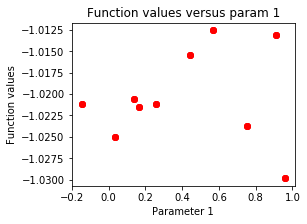

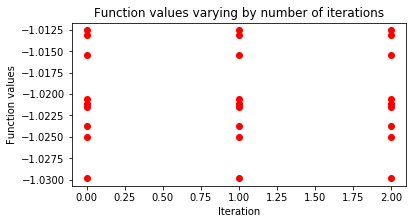

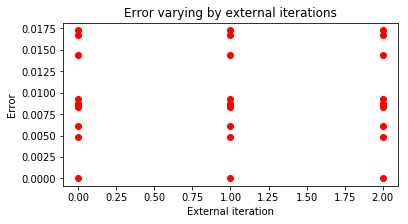

In [32]:
display_data(results, 0.0)